In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X, y = mnist.data, mnist.target

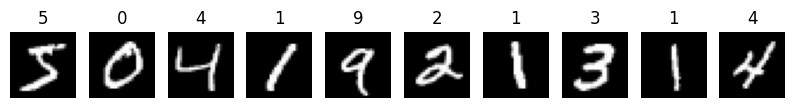

X: 70000  Y: 70000


In [2]:
import matplotlib.pyplot as plt

# Reshape one sample to 28x28 and plot first 10 images
fig, axes = plt.subplots(1, 10, figsize=(10, 3))
for i, ax in enumerate(axes):
    ax.imshow(X.iloc[i].values.reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(y[i])

plt.show()
X = X/255
X = [X.iloc[i].values.reshape(28, 28).tolist() for i in range(X.shape[0])]
y = y.tolist()
print(f'X: {len(X)}  Y: {len(y)}')

In [3]:
import sys
import os

sys.path.append(os.path.abspath(".."))

from graphviz import Digraph
from src.nn import CNN
import random

network = CNN([(28, 28), (3, 3), 2], [32, 16, 1])

In [4]:
# Tracing and drawing graph

def trace(root):
    nodes, edges = set(), set()
    param_nodes = network.parameters()
    def build(node):
        if node not in nodes:
            nodes.add(node)

            if len(node._prev) == 0 and node not in param_nodes:
                node.label = "input"

            for n in node._prev:
                edges.add((n, node))
                build(n)
    
    build(root)
    return nodes, edges

def build_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # Left to right graph

    nodes, edges = trace(root)
    for node in nodes:
        uid = str(id(node))

        dot.node(name=uid, label=f'{node.label} | data {node.data:.4f} | grad {node.grad:.4f}', shape='record')

        if node._op:
            dot.node(name=uid+node._op, label=node._op)
            dot.edge(uid+node._op, uid)
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2))+n2._op)
    
    return dot

In [5]:
targets = [-0.9+0.2*x for x in range(10)]

def fetch_training_data(n=1000):
    r = random.randrange(0, 50000-n)
    return X[r:r+n], y[r:r+n]

def fetch_testing_data(n=1000):
    r = random.randrange(50000, 70000-n)
    return X[r:r+n], y[r:r+n]

def check_target(x):
    for i in range(len(targets)):
        if targets[i]-0.1 < x.data < targets[i]+0.1:
            return i

In [6]:
# x_samp, y_samp = X[1], y[1]

# L = (network(x_samp)-targets[int(y_samp)])**2
# build_dot(L)

In [7]:
training_cycles = 10
step = 0.01
exp_decay_factor = 0.95
batch_size = 100

for i in range(training_cycles):
    x_batch, y_batch = fetch_training_data(batch_size)

    outs = [network(ins) for ins in x_batch]
    print(outs)
    L = sum((out-targets[int(exp)])**2 for out, exp in zip(outs, y_batch))

    for p in network.parameters(): # Make sure to zero the grads!
        p.grad = 0
    
    L.backward() # Backward step

    for p in network.parameters(): # Modify weights based on grads
        p.data += -(step * exp_decay_factor)**i * p.grad
    
    print(f'Training step {i+1}: {L.data} loss')

[Value(data=-0.8528421468818155, grad=0.0), Value(data=-0.6707131755190231, grad=0.0), Value(data=-0.8731696979311213, grad=0.0), Value(data=-0.19766655905998473, grad=0.0), Value(data=-0.5954599601709375, grad=0.0), Value(data=-0.897869933870752, grad=0.0), Value(data=-0.9655789998109973, grad=0.0), Value(data=-0.3873883227675037, grad=0.0), Value(data=-0.9903219556945976, grad=0.0), Value(data=-0.5029430077034873, grad=0.0), Value(data=-0.8767465435223858, grad=0.0), Value(data=0.4312440622861041, grad=0.0), Value(data=-0.3798002596713226, grad=0.0), Value(data=-0.4618898233166412, grad=0.0), Value(data=-0.61894618046654, grad=0.0), Value(data=-0.11103154352354926, grad=0.0), Value(data=-0.4437852366126916, grad=0.0), Value(data=0.3276349294131238, grad=0.0), Value(data=-0.8416419339008707, grad=0.0), Value(data=-0.675269435672507, grad=0.0), Value(data=0.9803195278157995, grad=0.0), Value(data=-0.9967438100533622, grad=0.0), Value(data=-0.890405958439264, grad=0.0), Value(data=-0.84

OverflowError: math range error

In [16]:
test = 100
correct = 0
x_batch, y_batch = fetch_testing_data(test)
for i in range(len(x_batch)):
    pred, actual = network(x_batch[i]), int(y_batch[i])
    print(f'Predicted: {pred}; Actual: {actual}')

    if check_target(pred) == actual:
        correct += 1
    
print(f'Predicted {correct} out of {test}')

Predicted: Value(data=-0.9999999999998797, grad=0.0); Actual: 0
Predicted: Value(data=-0.9999999999998792, grad=0.0); Actual: 6
Predicted: Value(data=-0.9999999999998792, grad=0.0); Actual: 2
Predicted: Value(data=-0.9999999999998798, grad=0.0); Actual: 3
Predicted: Value(data=-0.9999999999998795, grad=0.0); Actual: 1
Predicted: Value(data=-0.9999999999998787, grad=0.0); Actual: 5
Predicted: Value(data=-0.9999999999998797, grad=0.0); Actual: 1
Predicted: Value(data=-0.9999999999998784, grad=0.0); Actual: 8
Predicted: Value(data=-0.9999999999998792, grad=0.0); Actual: 5
Predicted: Value(data=-0.9999999999998797, grad=0.0); Actual: 9
Predicted: Value(data=-0.9999999999998797, grad=0.0); Actual: 4
Predicted: Value(data=-0.9999999999998795, grad=0.0); Actual: 0
Predicted: Value(data=-0.9999999999998792, grad=0.0); Actual: 7
Predicted: Value(data=-0.9999999999998788, grad=0.0); Actual: 5
Predicted: Value(data=-0.99999999999988, grad=0.0); Actual: 8
Predicted: Value(data=-0.9999999999998783,